In [62]:
## Single gaussian model
import cv2
import os
from numpy import *
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


FOLDER_PATH='H:\\NCSU\\Courses\\Sem2\\CV\\Project\\'
def display_image(image):
	cv2.imshow('image', image)
	cv2.waitKey(0)
	cv2.destroyAllWindows()
    
def load_images_from_folder(folder_name):
	folder=FOLDER_PATH+'{}'.format(folder_name)
	imgs_flat = []
	for file in os.listdir(folder):
		img = cv2.imread(os.path.join(folder,file))
		gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 		hist = cv2.equalizeHist(gray_img)
		gray_img = cv2.resize(gray_img, (10,10))
		img_flat = hist.ravel()
# 		img_flat = img.ravel()
		imgs_flat.append(np.array(img_flat))
	return np.array(imgs_flat)

#Load Data 
def load_images(file_path):
    imgs_flat = []
    for file in glob.glob(file_path): 
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#       hist = cv2.equalizeHist(gray_img)
        gray = cv2.resize(gray_img,(10,10))
        img_flat = gray.ravel()
        imgs_flat.append(img_flat) 
    return np.array(imgs_flat)

def calculate_gaussian_pdf(data, mu, sig):
	sig_inv = np.linalg.inv(sig)
	det = np.linalg.det(sig)
# 	print (det)
	temp = data-mu
	term = np.matmul(np.matmul(temp,sig_inv), temp.T)
	exp_term = math.exp(-0.5*term)
	pdf = exp_term/math.sqrt(det) 
	return pdf


In [63]:
## Load Training and Test Data
positive_train = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Positive\\*.jpg")
negative_train = load_images('H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Negative\\*.jpg')
test_pos_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Positive\\*.jpg")
test_neg_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Negative\\*.jpg")

# Mean and Covariance
# print (positive_train.shape)
# print (negative_train.shape)
mu_pos = np.mean(positive_train, axis=0)
mu_neg = np.mean(negative_train, axis=0)

#Visualize Mean 
mean_image = np.array(mu_pos,dtype="uint8").reshape(10,10)
mean_image = cv2.resize(mean_image, (60,60))
cv2.imwrite("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model1_mean_pos.jpg",mean_image)
mean_image = np.array(mu_neg,dtype="uint8").reshape(10,10)
mean_image = cv2.resize(mean_image, (60,60))
cv2.imwrite("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model1_mean_neg.jpg",mean_image)


sig_pos = np.cov(positive_train.T)
sig_neg = np.cov(negative_train.T)

#Visualize Covariance 
covar_diag = np.rint(np.diag(sig_pos))
covar_diag = np.rint(255 * covar_diag / max(covar_diag))
covar_array = np.array(covar_diag, dtype='uint8')
covar_image = covar_array.reshape(10,10)
covar_image = cv2.resize(covar_image, (60,60))
cv2.imwrite("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model1_cov_pos.jpg",covar_image)


covar_diag = np.rint(np.diag(sig_neg))
covar_diag = np.rint(255 * covar_diag / max(covar_diag))
covar_array = np.array(covar_diag, dtype='uint8')
covar_image = covar_array.reshape(10,10)
covar_image = cv2.resize(covar_image, (60,60))
cv2.imwrite("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model1_cov_neg.jpg",covar_image)

# print (mu_pos)
# print (mu_neg)
# print (sig_pos)
# print (sig_neg)

True

In [64]:
##Calculate Predictions
pred = []
def calc_predictions(test_img, mu_pos, sig_pos, mu_neg, sig_neg):
    for test in test_img:
        face_pdf = calculate_gaussian_pdf(test, mu_pos, sig_pos)
        non_face_pdf = calculate_gaussian_pdf(test, mu_neg, sig_neg)
        posterior = (face_pdf)/(non_face_pdf+face_pdf)
        pred.append(posterior)

In [65]:
##Evaluation of Learned model Performance
def print_result(accuracy, false_postive_rate, false_negative_rate, misclass):
    print("\nResults: ")
    print("----------")
    print("Accuracy: "+str(accuracy))
    print("False positive rate: "+str(false_postive_rate/100))
    print("False negative rate: "+str(false_negative_rate/100))
    print("Misclassification rate: "+str(misclass))
    
def calc_accuracy(probability_pred, original):
    probability_pred = [ round(elem,2) for elem in probability_pred ]
    predictions = []
    for i in probability_pred:
        if i > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    match_count = 0
    for x,y in zip(original, predictions):
        if x==y:
            match_count+=1
    accuracy = match_count/len(predictions)
    misclass = 1-accuracy
    false_postive_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==1:
            false_postive_rate +=1    
    false_negative_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==0:
            false_negative_rate+=1 
    print_result(accuracy, false_postive_rate, false_negative_rate, misclass)  

    return probability_pred

In [66]:
## Prediction and Evaluation
#Test data - Faces
original_pos = [1]*100
calc_predictions(test_pos_img, mu_pos, sig_pos, mu_neg, sig_neg)

#Test data - Non Faces
original_neg = [0]*100
calc_predictions(test_neg_img, mu_pos, sig_pos, mu_neg, sig_neg)
original = original_pos + original_neg
probability_pred = calc_accuracy(pred, original)


Results: 
----------
Accuracy: 0.925
False positive rate: 0.15
False negative rate: 0.0
Misclassification rate: 0.07499999999999996


In [67]:
##Plot ROC curve
def plot_ROC(original, predictions):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(original, predictions)
    roc_auc = roc_auc_score(original,predictions)
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.show()

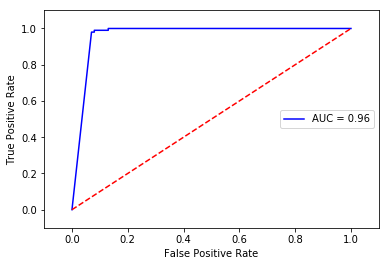

In [68]:
plot_ROC(original,pred)